In [1]:
%matplotlib inline
import mne
import matplotlib.pyplot as plt

fname = "oddball-epo.fif"

epochs = mne.read_epochs(fname)#epochs haben Zeit, Raum und Trial Dimension

Reading oddball-epo.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     500.00 ms
        0 CTF compensation matrices available
212 matching events found
Applying baseline correction (mode: mean)
212 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated


## Evokeds

Finally, if we average an epoched dataset over trials, we can use the `mne.Evoked` object.

In [2]:
target = epochs["target"].average()
target

<Evoked  |  'target/stimulus' (mean, N=106), [-0.2, 0.5] sec, 63 ch, ~153 kB>

In [3]:
standard = epochs["standard"].average()

To quickly investigate evoked activity, the `Evoked` object has a number of plotting functions available.

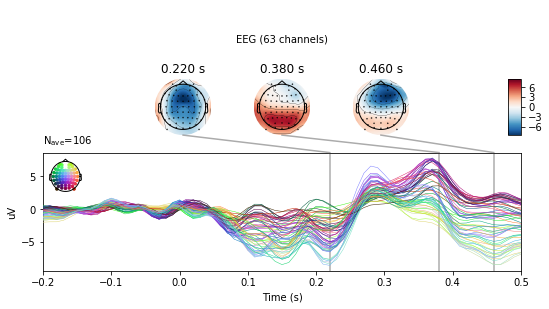

In [4]:
target.plot_joint(); # nicht interpretierbar, können nur kontrast zwischen Bedingungen vergleichen

For condition contrasts, you can use `mne.combine.evoked`:

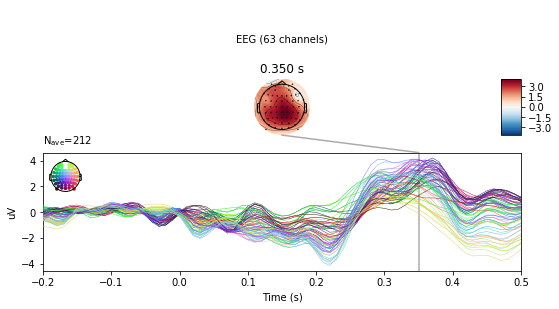

In [5]:
diff = mne.combine_evoked((target, -standard), weights='equal') #deswegen ziehen wir von target trials standard trials ab
# isolieren den Frequenzeffekt
diff.plot_joint(times=.35); #hier welchen timepoint man will. Default sind 3 Punkte (größte 3 lokale peaks)

Or as an image:

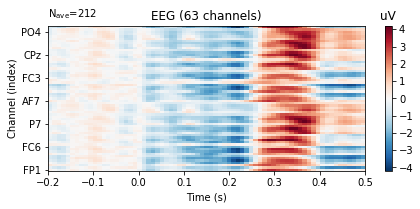

In [6]:
diff.plot_image();

Because we have a 10/20 electrode layout, we can easily use a somewhat nicer layout:

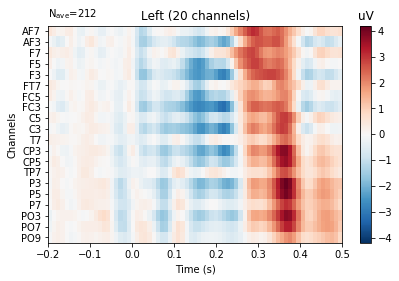

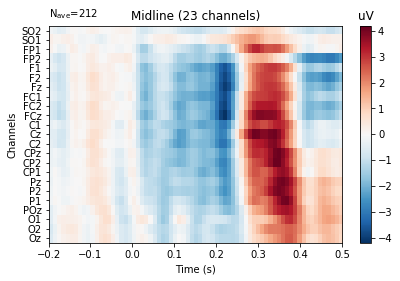

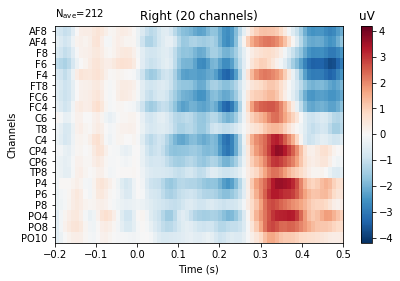

In [8]:
rois = mne.channels.make_1020_channel_selections(diff.info, midline="z12") #1020 system ist das was wir benutzen 
diff.plot_image(group_by=rois, show=False, show_names="all");

To contrast multiple conditions, `mne.viz.plot_compare_evokeds` is available:

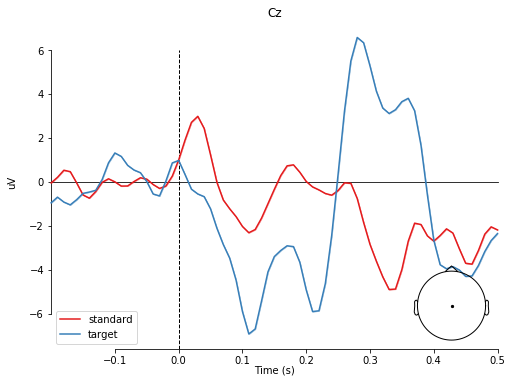

In [9]:
mne.viz.plot_compare_evokeds({"standard": standard,
                              "target": target}, picks=[13]);

## Time-Frequency stuff

For an overview over the spectral shape of the data, we can use a plotting method of `raw`, `raw.plot_psd`:

In [10]:
epochs_for_tfr = mne.read_epochs("oddball-long-epo.fif")

Reading oddball-long-epo.fif ...
Isotrak not found
    Found the data of interest:
        t =    -500.00 ...    1500.00 ms
        0 CTF compensation matrices available
212 matching events found
Applying baseline correction (mode: mean)
212 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated


    using multitaper spectrum estimation with 7 DPSS windows


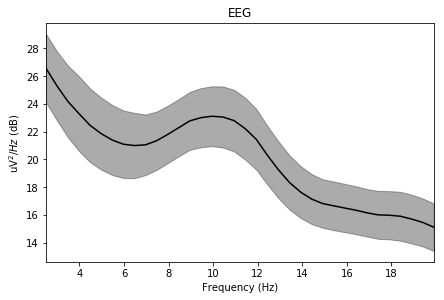

In [11]:
epochs_for_tfr.plot_psd(fmin=2, fmax=20);

But what about the time/frequency correlates of the Oddball effect?

We will extract power per time and frequency with Morlet wavelets.

In [12]:
from mne.time_frequency import tfr_morlet

In [13]:
freqs = list(range(3, 30))
tfr_target = tfr_morlet(epochs_for_tfr["target"], freqs, 3, return_itc=False)#zusätzliche Dimensionalität: FrequenzxChannelxZeitpunkt
tfr_standard = tfr_morlet(epochs_for_tfr["standard"], freqs, 3, return_itc=False)

Time-frequency data (single trial or averaged) is stored in TFR objects. These objects behave in many ways like Evoked objects ...

In [14]:
tfr_contrast = mne.combine_evoked((tfr_standard, tfr_target), (-.5, .5))
tfr_contrast.apply_baseline((None, 0))

Applying baseline correction (mode: mean)


<AverageTFR  |  time : [-0.500000, 1.500000], freq : [3.000000, 29.000000], nave : 212, channels : 63, ~2.7 MB>

Plotting time-frequencyy activity (event-related spectral perturbations): observe the alpha-band ERD and the time-frequency correlates of the P3 effect.

No baseline correction applied
No baseline correction applied


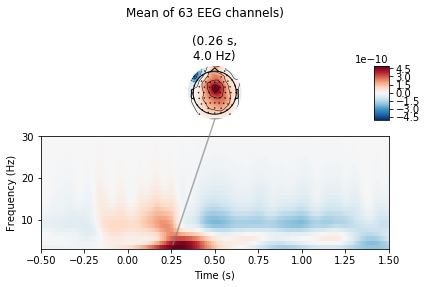

In [15]:
tfr_contrast.plot_joint(); #alpha geht hoch kurz nach target, geht runter wenn target kommt

No baseline correction applied


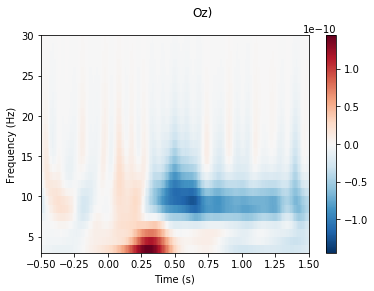

In [16]:
tfr_contrast.plot(picks=[27]);

In [17]:
del epochs_for_tfr

## Statistics

Remember what the data look like:

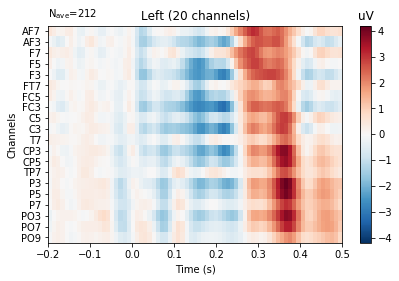

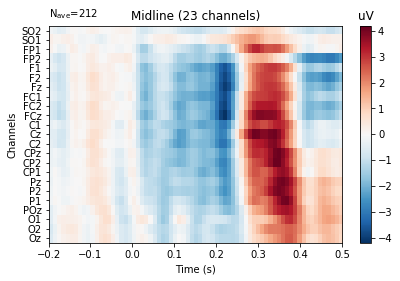

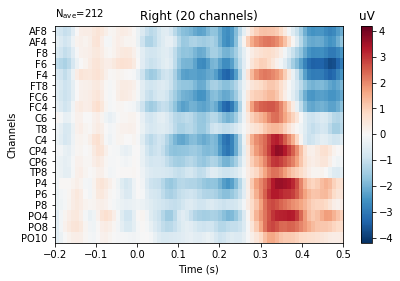

In [18]:
diff.plot_image(group_by=rois, show=False, show_names="all");

Can we statistically threshold this image to see which effects are reliable?

### Cluster-based permutation stats

Exploratory analysis with nonparametric control of the error rate is commonly done with
cluster-based permutation tests (i.e., Maris 2012). To cluster across space, we first need a
channel adjacency matrix.

Could not find a connectivity matrix for the data. Computing connectivity based on Delaunay triangulations.
-- number of connected vertices : 63


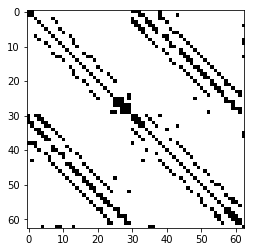

In [19]:
from mne.channels import find_ch_connectivity
connectivity, ch_names = find_ch_connectivity(epochs.info, ch_type='eeg')
plt.imshow(connectivity.toarray(), cmap="Greys")

Now we need the data in the right shape. Sadly, because the space dimension needs
to be last, we need to manually swap the time and space axes.

In [20]:
epochs.pick_types(eeg=True)
target_epochs, standard_epochs = epochs["target"].get_data(), epochs["standard"].get_data()
target_epochs.shape, standard_epochs.shape #63 channels, 71 Zeitpunkte, 106 trials

((106, 63, 71), (106, 63, 71))

In [21]:
target_epochs = target_epochs.swapaxes(1, 2)
standard_epochs = standard_epochs.swapaxes(1, 2)
target_epochs.shape, standard_epochs.shape

((106, 71, 63), (106, 71, 63))

MNE has various cluster-based permutation test options. Here, we test for single-trial
differences between conditions with `mne.stats.spatio_temporal_cluster_test`.

We use threshold-free cluster enhancement to reduce the number of parameters.

Warning: the next cell takes a lot of time and computational power.

In [22]:
from mne.stats import spatio_temporal_cluster_test

mne.set_log_level(True)
tfce = dict(start=.2, step=.5)  # decrease both for real analyses .1 & .2
cluster_stats = spatio_temporal_cluster_test([target_epochs, standard_epochs],
                                             threshold=tfce,
                                             n_permutations=200,  # way too low, increase for real analyses
                                             n_jobs=1,  # increase for decent CPUs
                                             connectivity=connectivity)
T_obs, clusters, p_values, _ = cluster_stats

stat_fun(H1): min=0.000000 max=75.314187
Running initial clustering
Using 151 thresholds from 0.20 to 75.20 for TFCE computation (h_power=2.00, e_power=0.50)
Found 4473 clusters
Permuting 199 times...
[......................................  ] 96.48%  -   Computing cluster p-values
Done.


Now we can visualise the *t* values over time and space ...

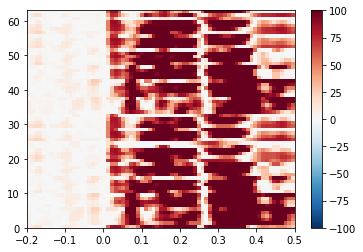

In [23]:
extent = (*epochs.times[[0, -1]], 0, len(epochs.ch_names))
im = plt.imshow(T_obs.T, aspect="auto", cmap="RdBu_r",
                vmin=-100, vmax=100, extent=extent
          )
plt.colorbar(im)

... and the p-values.

703


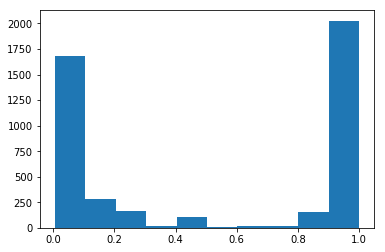

In [24]:
plt.hist(p_values)

alpha = .01
print(sum(p_values < alpha))

We can use the resulting mask to mask the image:

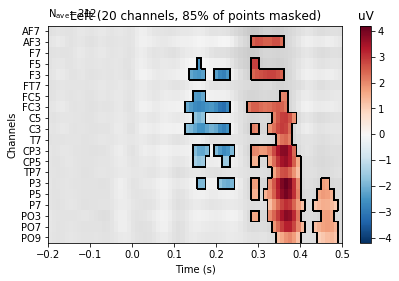

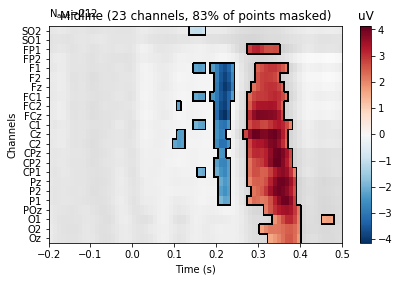

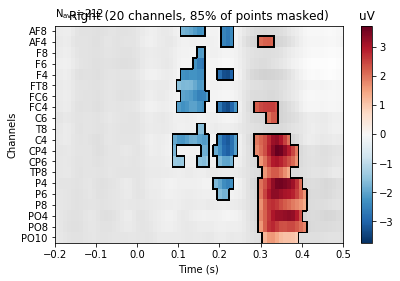

In [26]:
pvals = p_values.reshape(T_obs.shape).T < alpha

diff.plot_image(group_by=rois, show=False, show_names="all", mask=pvals);#fehlerkontrolle für die Existenz des Clusters
#nicht für die Ausdehnung. In diesen Clustern gibt es signifikante Effekte FÜR DIE PUNKTE NICHT DEN GESAMTEN CLUSTER

### Parametric stats
Sometimes, e.g. because we wish to test a specific hypothesis, cluster-based permutation tests are too much.
We can also simply access the data in array form and test with parametric (or nonparametric) tests.

For this, we first need to identify the spatial and temporal coordinates of an effect we want to test -
for example, the N2 at Cz.

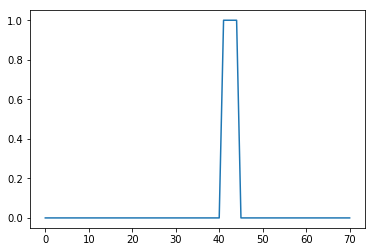

In [27]:
time_mask = (.2 < epochs.times) & (epochs.times < .25) #kreiert maske für zeitraum und elektrode
electrode_pz = epochs.ch_names.index("Cz")
plt.plot(time_mask)

Now we extract the target data. Reminder: the shape of epochs data is (trial, channel, time)

In [28]:
epochs["target"].get_data().shape

(106, 63, 71)

In [29]:
cond_a = epochs["target"].get_data()[:, electrode_pz, time_mask].mean(-1)
cond_b = epochs["standard"].get_data()[:, electrode_pz, time_mask].mean(-1)
#average über Zeit

In [30]:
cond_a.shape

(106,)

Now we can simply use ordinary tests on these statistics.

In [32]:
from scipy.stats import ttest_ind, wilcoxon

In [33]:
ttest_ind(cond_a, cond_b)

Ttest_indResult(statistic=-3.185398761411968, pvalue=0.0016656107775993411)

In [34]:
wilcoxon(cond_a, cond_b)

WilcoxonResult(statistic=1726.0, pvalue=0.0004704838864446639)

It is also straight-forward to convert the data into a (pandas) dataframe.

In [35]:
df = epochs.to_data_frame()
df.head(20)

Converting time column to int64...


signal                           FP1       FP2        F7        F3        Fz  \
condition       epoch time                                                     
target/stimulus 0     -200 -5.569638 -5.620327 -5.143945 -6.102057 -6.590915   
                      -190 -4.125365 -4.376233 -5.671656 -6.001161 -4.426533   
                      -180  0.644387  0.442166 -2.787724 -0.234391  1.587101   
                      -170  4.837009  5.683911  1.896734  6.945924  7.605806   
                      -160  5.234026  7.023589  4.889885  8.439270  8.961994   
                      -150  2.446711  4.123464  4.129998  3.297352  5.563580   
                      -140 -0.212151  0.987076  1.123524 -1.851821  1.969872   
                      -130 -0.063626  1.172609 -0.462390 -0.886379  2.358552   
                      -120  2.786056  3.937428  1.397331  4.717169  6.296919   
                      -110  5.821941  5.757677  4.904049  8.458177  9.647376   
                      -100  6.319146  4.713763  6.433874  6.873139  9.018731   
                      -90   3.611328  2.088468  4.485461  2.577878  4.735442   
                      -80  -0.481640 -0.187137  0.971669 -0.427323 -0.415017   
                      -70  -3.465491 -2.052449 -1.368172 -1.698720 -4.375419   
                      -60  -4.230542 -4.289942 -1.813223 -3.142912 -6.874207   
                      -50  -3.229532 -6.036217 -1.398906 -4.775692 -7.821285   
                      -40  -1.347336 -5.207910 -0.891108 -4.403704 -6.480060   
                      -30   0.440080 -1.782598 -0.394073 -1.594121 -3.326739   
                      -20   0.586042  0.848919 -0.625141  0.355271 -1.532433   
                      -10  -2.336079 -0.857600 -2.855028 -2.135820 -4.474064   

signal                            F4        F8       FC5       FC1       FC2  \
condition       epoch time                                                     
target/stimulus 0     -200 -6.524084 -6.713595 -4.874041 -5.635165 -8.902956   
                      -190 -4.841483 -6.066758 -5.139759 -3.654862 -5.780726   
                      -180  1.352367 -2.675967 -2.783668  1.767728  1.186872   
                      -170  7.687755  1.652572  1.320385  7.312994  7.313466   
                      -160  8.904087  3.517696  4.127907  8.347743  8.187539   
                      -150  5.305224  2.325227  3.352659  4.118737  4.455236   
                      -140  2.033142  0.925816  0.194371 -0.922277  0.752946   
                      -130  2.634131  1.792548 -1.356883 -1.503564  0.775068   
                      -120  5.448726  4.075488  1.289932  2.913853  4.142575   
                      -110  6.651919  5.176076  6.026810  7.566261  7.527547   
                      -100  4.989593  4.128799  7.992621  7.612440  7.952526   
                      -90   2.144275  2.155381  5.064429  3.216245  4.964993   
                      -80  -0.566900  0.349661  0.282193 -1.405977  0.247391   
                      -70  -3.726683 -1.572927 -1.929193 -3.342465 -4.170382   
                      -60  -7.508256 -3.731107 -0.893834 -3.602454 -6.915334   
                      -50  -9.578744 -4.629578  0.325246 -4.089539 -7.006521   
                      -40  -7.273247 -2.668658 -0.509138 -4.220012 -4.059588   
                      -30  -1.756968  1.135141 -2.214366 -2.575431  0.242446   
                      -20   1.829049  3.271738 -2.769867 -0.732362  1.873172   
                      -10  -0.450403  1.228094 -2.805227 -2.498330 -2.295151   

signal                        ...           P5         P1        P2        P6  \
condition       epoch time    ...                                               
target/stimulus 0     -200    ...    -1.433939  -0.818473 -0.597176  2.593392   
                      -190    ...    -1.099729  -2.437520 -2.730614 -0.353572   
                      -180    ...    -0.287896  -1.384971 -1.557908 -2.366775   
                      -170    ...     2.275740   3.617918  3.101639 -1.44

In [37]:
df_cz = df.query("200 < time < 250")["Cz"].groupby(["epoch", "condition"]).mean().reset_index()
df_cz.head(10)

,epoch,condition,Cz
0,0,target/stimulus,3.020595
1,1,standard/stimulus,2.480755
2,2,target/stimulus,-3.826423
3,3,standard/stimulus,3.490718
4,4,target/stimulus,-8.976194
5,5,standard/stimulus,1.710783
6,6,target/stimulus,2.854992
7,7,standard/stimulus,-10.142047
8,8,standard/stimulus,-12.046273
9,9,target/stimulus,-14.502221


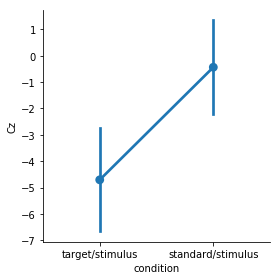

In [38]:
import seaborn as sns
sns.factorplot(y="Cz", data=df_cz, x="condition")